# Investigate customer demographics
Iga Świtalska

## Introduction

In this report we are going to use machine learnig technics to develop our project. For a reminder, we are working on data, which came from ubiqum code academy and relates to online and in-store sales of electronic components. Data contains five features:

* "in-store": an information if transaction was made online or in-store (0 - online, 1 - in-store),
* "age": age of customers (continous data),
* "items": number of items purchased (from 1 to 8),
* "amount": amount clients has spent (continous data),
* "region": a region, where transaction was made:
    * 1 - the North,
    * 2 - the South,
    * 3 - the East,
    * 4 - the West.

We want to focus on undermentioned questions:

* Are there differences in the age of customers between regions? If so, can we predict the age of a customer in a region based on other demographic data?
* Is there any correlation between age of a customer and if the transaction was made online or in the store? Do any other factors predict if a customer will buy online or in our stores?

## Obtaining and preprocessing Data

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

We have to download data from .csv file, remove duplicates and check if data contains missing values.

In [2]:
# obtaing data
data = pd.read_csv('Demographic_Data.csv')

In [3]:
# removing duplicates
data = data.drop_duplicates()

In [4]:
# detection of missing values
print(data.isnull().sum())

in-store    0
age         0
items       0
amount      0
region      0
dtype: int64


In [5]:
data.head()

,in-store,age,items,amount,region
0,0,37,4,281.03,2
1,0,35,2,219.51,2
2,1,45,3,1525.70,4
3,1,46,3,715.25,3
4,1,33,4,1937.50,1


For facilitation of future analysis we will create individual variables for each column of data frame.

In [6]:
age = data['age'].copy()

In [7]:
region = data['region'].copy()

In [8]:
in_store = data['in-store'].copy()

In [9]:
amount = data['amount'].copy()

In [10]:
items = data['items']

## Age discretization

To answer the first question "Are there differences in the age of customers between regions?" we have to discretize age first.

Dividing our data into five bins will help us to see better the distribution without any noise and find the correlation with other features.

In [11]:
# dividing data into 5 bins
age_bins = pd.cut(age, bins=np.arange(10,100,15), labels=False)

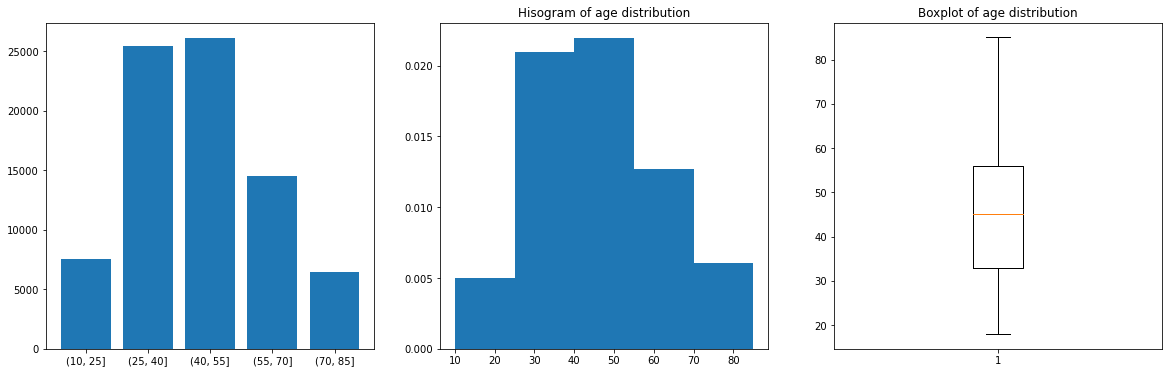

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,6))

ax1.bar(['(10, 25]','(25, 40]','(40, 55]','(55, 70]','(70, 85]'],np.ravel(age_bins.value_counts(sort=False)));
ax2.hist(age,density=True,bins=np.arange(10,100,15));
ax2.set_title('Hisogram of age distribution')
ax3.boxplot(age)
ax3.set_title('Boxplot of age distribution')

plt.show()

We can see that the most of customers are between 25 and 55 years old. And there are few clinets with age lower than 25 and higher than 70. Infromations that we can read from boxplot of continuous data are similar. The average age is around 45 years, the first and the third quartile lie near to 30 and 60 years. Values lower than 30 and higher than 60 are outliers.

Therefore we can say that we are not losing too many information discretizing data.

## Are there differences in the age of customers between regions?

In [14]:
data['age'] = age
data['region'] = region.map({1:'north',2:'south',3:'east',4:'west'})
region_age = data.groupby(['region'])['age']

Basic descriptive statistics to see how the average age, standard deviation and quartiles change in different regions:

In [15]:
region_age.describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
east,18000.0,45.646944,14.417935,18.0,34.0,45.0,57.0,74.0
north,15997.0,43.704132,14.085525,19.0,32.0,43.0,53.0,74.0
south,19994.0,56.609083,16.537368,28.0,42.0,57.0,71.0,85.0
west,25988.0,38.752424,11.886239,18.0,29.0,39.0,49.0,63.0


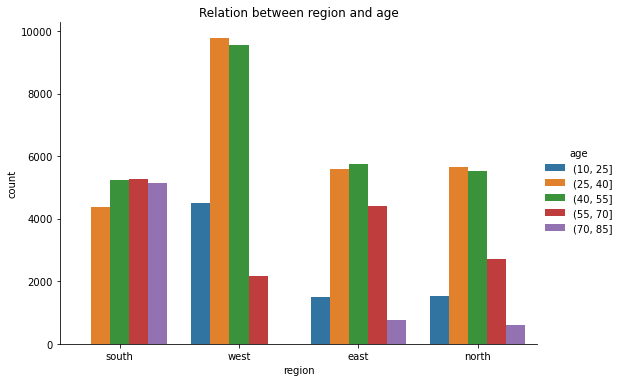

In [16]:
data['age'] = pd.cut(age, bins=np.arange(10,100,15))
data['region'] = region.map({1:'north',2:'south',3:'east',4:'west'})
sns.catplot(x='region',y=None,hue='age',data=data, kind="count", aspect=1.5)
plt.title('Relation between region and age')
plt.show()

As we can see in bar plots age of customers is different in each region. 

In the West, where the average age is the lowest, there are not customers between 70 and 85 yeras old and the standard deviation is the highest.
On the other side in the southtern part there are not clients younger than 25 years and the the average age is the lowest. In this case values are not very dispersed from the mean.
In the East and the North age distribution is similar.

## Is there any correlation between age of a customer and if the transaction was made online or in the store?

To answer this question we will also use discretized age data.

In [17]:
data['in-store'] = in_store.map({1:True,0:False})
data['age'] = age
in_store_age = data.groupby(['in-store'])['age']

Basic descriptive statistics for in-store and online purchases:

In [18]:
in_store_age.describe()

,count,mean,std,min,25%,50%,75%,max
in-store,,,,,,,,
False,39989.0,48.558654,16.901714,18.0,35.0,48.0,60.0,85.0
True,39990.0,42.958440,13.877687,19.0,32.0,42.0,52.0,74.0


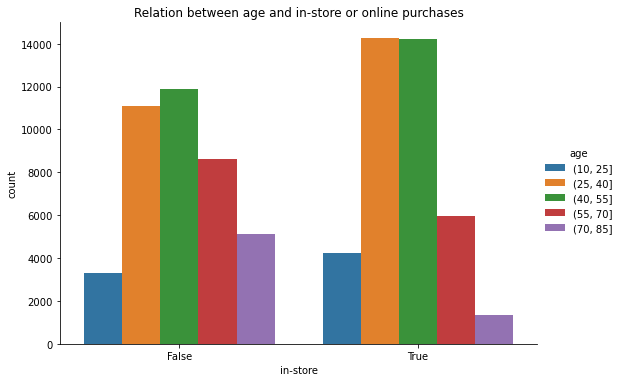

In [19]:
data['age'] = pd.cut(age, bins=np.arange(10,100,15))
data['in-store'] = in_store.map({1:True,0:False})
sns.catplot(x='in-store',y=None,hue='age',data=data, kind='count', aspect=1.5)
plt.title('Relation between age and in-store or online purchases')
plt.show()

As we can see for online purchases the average age is higher.
From barplots we can read the same thing: older people prefer to buy online and younger people in store. 

## Relation between age, amount and online or in-store purchases

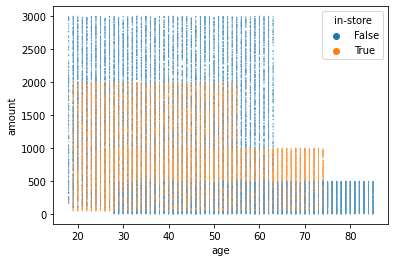

In [161]:
sns.scatterplot(x=age, y=amount, hue='in-store', data=data, marker='o', s=1) 
plt.show()

Another interesting thing to do is to compare three features: "age", "amount" and "in-store". In the scatterplot above we can see that young people spend more money online. At the age of 60 they start to spend more on in-store transation. Customers with age around 80 years buy only in shops.

## Can we predict the age of a customer in a region based on other demographic data?

From now, we start a prediction of our features using data mining and machine learning. We will try to find the best model which fits to our data and than predict the age of customer based on other demographic data.

### Preparing data for machine learning

First we have to prepare data and split it into dependent values "x data" and traget value "y data", which we want to predict. In this case our dependent values are: number of items, amount spent, region and the information if sales were made online or in-store. Our target value is discretized age.

We will also split "x data" and "y data" into two parts: a training set (in which we will train our model) and a test set (the "simulation of real world"). In other words, we want to train a model on a traing set and see how well it can predict values from a test set.

But before we will do that, we are going to use cross validation to see which number of bins (in age discretization process) is the best to build a model. The maximum depth of desicion tree is equal to 5 for Decision Tree Classifier and Random Forest Classifier.

In [20]:
data['in-store'] = in_store
data['amount'] = amount
data['region'] = region
x_data = data[['in-store', 'items', 'amount', 'region']]

Using cross validation to see how accuracy changes, for different numbers of bins:

In [21]:
bins_results = []
bins_number = []

for n in range(2,11):
    y_data = pd.qcut(age, q=n, labels=False)
    model = DecisionTreeClassifier(max_depth=5)

    result = cross_val_score(model, x_data, y_data, cv=5, scoring='accuracy')  #using cross validation
    name = '{} bins:'.format(n)

    bins_number.append(name)
    bins_results.append(result)

print('Decision Tree Classifier:')
for i in range(len(bins_number)):
    print(bins_number[i],bins_results[i].mean())

Decision Tree Classifier:
2 bins: 0.6368296645902645
3 bins: 0.46823540989967716
4 bins: 0.3840633274917667
5 bins: 0.3222845778653166
6 bins: 0.2819615133542685
7 bins: 0.25337896837447876
8 bins: 0.23082305040155005
9 bins: 0.22132055520913677
10 bins: 0.1996023857480469


In [22]:
bins_results = []
bins_number = []

for n in range(2,11):
    y_data = pd.qcut(age, q=n, labels=False)
    model = RandomForestClassifier(max_depth=5)

    result = cross_val_score(model, x_data, y_data, cv=5, scoring='accuracy')
    name = '{} bins:'.format(n)

    bins_number.append(name)
    bins_results.append(result)

print('Random Forest Classifier:')
for i in range(len(bins_number)):
    print(bins_number[i],bins_results[i].mean())

Random Forest Classifier:
2 bins: 0.6367796442702423
3 bins: 0.4689730880672653
4 bins: 0.3845134423649676
5 bins: 0.3232348521641195
6 bins: 0.28272423373114297
7 bins: 0.25474182237338017
8 bins: 0.23131067934223318
9 bins: 0.22167064663946542
10 bins: 0.2008902358443628


For two bins the accuracy is the highest, so we will choose this discretization. The results for Desicion Tree and Random Forest are similar. For future analysis I have chosen descision tree bcause it's easier to vizualize.

In [23]:
y_data = pd.qcut(age, q=2, labels=False)

We have two ranges with almost the same number of values:

In [24]:
pd.qcut(age, q=2).value_counts()

(17.999, 45.0]    41677
(45.0, 85.0]      38302
Name: age, dtype: int64

Now we have to split data into training and test sets.

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size = 0.3, random_state=100)

### Finding the best parametrs

To find the best combination of Decision Tree Classifier parameters we will use Grid Search, which check all the combinations of parameters and choose the model with the highest accuracy.

In [26]:
clf = GridSearchCV(DecisionTreeClassifier(),{
    'ccp_alpha':np.arange(0,0.05,0.01),
    'max_leaf_nodes':np.arange(2,11),
    'max_features':np.arange(1,5),
    'criterion':['gini','entropy']
},cv=5,return_train_score=False)

clf.fit(x_data,y_data)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04]),
                         'criterion': ['gini', 'entropy'],
                         'max_features': array([1, 2, 3, 4]),
                         'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [27]:
clf.best_params_

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_features': 4, 'max_leaf_nodes': 7}

### Decision Tree

In [28]:
# modeling (classification)
tree_model = DecisionTreeClassifier(ccp_alpha=0.0, criterion='gini', max_features=4 ,max_leaf_nodes=7,random_state=101)
model_fit = tree_model.fit(x_train,y_train)

In [29]:
# making predictions
preds = model_fit.predict(x_test)

We check precision, recall and f1-score. The confusion matrix tells us how many times we made good or bad predictions. 

In [30]:
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.63      0.74      0.68     12400
           1       0.66      0.53      0.58     11594

    accuracy                           0.64     23994
   macro avg       0.64      0.63      0.63     23994
weighted avg       0.64      0.64      0.63     23994



In [57]:
cm = confusion_matrix(y_test,preds)
cm

array([[9200, 3200],
       [5492, 6102]], dtype=int64)

In [59]:
print("True positive: {}, False negative (type II error, miss): {},\n False positive (type I error, false alarm): {}, True negative (correct rejection): {}".format(cm[0][0],cm[0][1],cm[1][0],cm[1][1]))

True positive: 9200, False negative (type II error, miss): 3200,
 False positive (type I error, false alarm): 5492, True negative (correct rejection): 6102


Interpreting decision tree below we can say that, if the customer is from the West is probably young (under 45 age). This observation isn't surprising, because the West is the region with the lowest average age. 

Another insights we can make, relate to people who spend less than 990. In the eastern part if a customer buys in-store is probably more than 45 years old, and if he choose online transactions we can predict that he is young. 

In the North and the South it is inversely. If custumer buys in-store is younger than 45 and if he buys online is elder. However we can't forget that in the North there are only in-store transactions and in the South only online purchases. So considering our model will have to say that, if the customer is from the South, he is also more than 45 years old. That make sence, because the South is the region with the highest average age. But that observation doesn't supply any new information.

Number of items does not appear in the tree. The reason is probably the zero correlation of "items data" with other features.

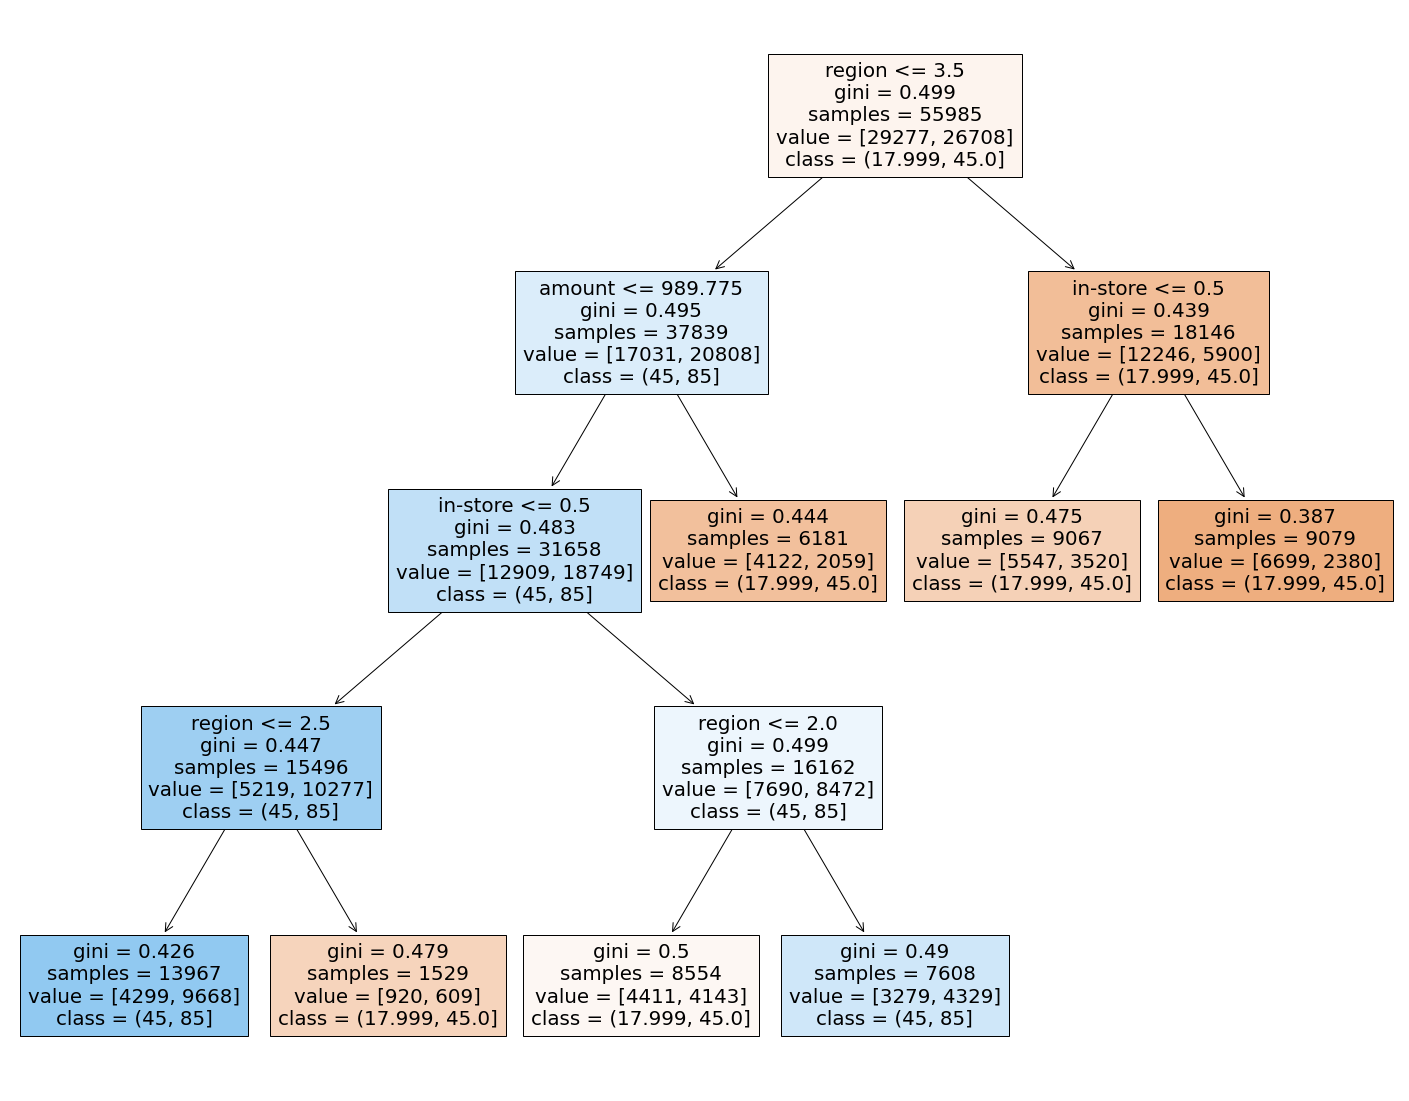

In [31]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(tree_model, feature_names=x_data.columns, class_names=['(17.999, 45.0]','(45, 85]'], filled=True)

## Do any factors predict if a customer will buy online or in stores?

In this case the procedure will be similar.

### Preparing data for machine learning

In [36]:
data['age'] = age
data['amount'] = amount
data['region'] = region
x_data2 = data[['age', 'items', 'amount', 'region']]

In [37]:
data['in-store'] = in_store
y_data2 = data['in-store']

In [38]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_data2, y_data2,test_size = 0.3, random_state=102)

### Finding the best parametrs

In [39]:
clf2 = GridSearchCV(DecisionTreeClassifier(),{
    'ccp_alpha':np.arange(0,0.05,0.01),
    'max_leaf_nodes':np.arange(2,11),
    'max_features':np.arange(1,5),
    'criterion':['gini','entropy']
},cv=5,return_train_score=False)

clf2.fit(x_data2,y_data2)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04]),
                         'criterion': ['gini', 'entropy'],
                         'max_features': array([1, 2, 3, 4]),
                         'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [40]:
clf2.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'gini',
 'max_features': 4,
 'max_leaf_nodes': 10}

In [43]:
print("Accuracy for the best parameters: " + str(clf2.best_score_))

Accuracy for the best parameters: 0.8860075717585227


### Decision Tree

In [47]:
# modeling (classification)
tree_model2 = DecisionTreeClassifier(ccp_alpha=0.0, criterion='gini', max_features=4 ,max_leaf_nodes=10,random_state=103)
model_fit2 = tree_model2.fit(x_train2,y_train2)

In [50]:
# making predictions
preds2 = model_fit2.predict(x_test2)

In [51]:
print(classification_report(y_test2, preds2, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87     12018
           1       0.81      1.00      0.90     11976

    accuracy                           0.89     23994
   macro avg       0.91      0.89      0.88     23994
weighted avg       0.91      0.89      0.88     23994



In [60]:
cm2 = confusion_matrix(y_test2,preds2)
cm2

array([[ 9287,  2731],
       [    1, 11975]], dtype=int64)

In [61]:
print("True positive: {}, False negative (type II error, miss): {},\n False positive (type I error, false alarm): {}, True negative (correct rejection): {}".format(cm2[0][0],cm2[0][1],cm2[1][0],cm2[1][1]))

True positive: 9287, False negative (type II error, miss): 2731,
 False positive (type I error, false alarm): 1, True negative (correct rejection): 11975


The last thing we will analyse in this report is decision tree, which can help us to predict if a sale was online or in store.

The first two observations aren't surprising. If the customer is from the North he choose in-store transactions and if he is from the South he prefer to buy oline. In the earlier report we observed that all transations from the North were in-store and all transactions from the South were online.

If the customer spends less then 1000, is from the eastern part and is less than 23 years old we can predict he would like to buy online and if he is elder he will choose in-store purchases. If he spends more than 1000 but less than 2000 and is from the South he will probably pay online. This insights corresponds with conclusions we have made analysing the firs decision tree.

If the client is from the West and is younger than 55 years old, he will go to the shop and if he is elder he will buy online.
We can make this observations regardless of amount, if we consider only transactions with amount below 2000.

The last insight we can make is that customers in the East and in the West prefer to pay online while making shopping which will cost more than 2000.

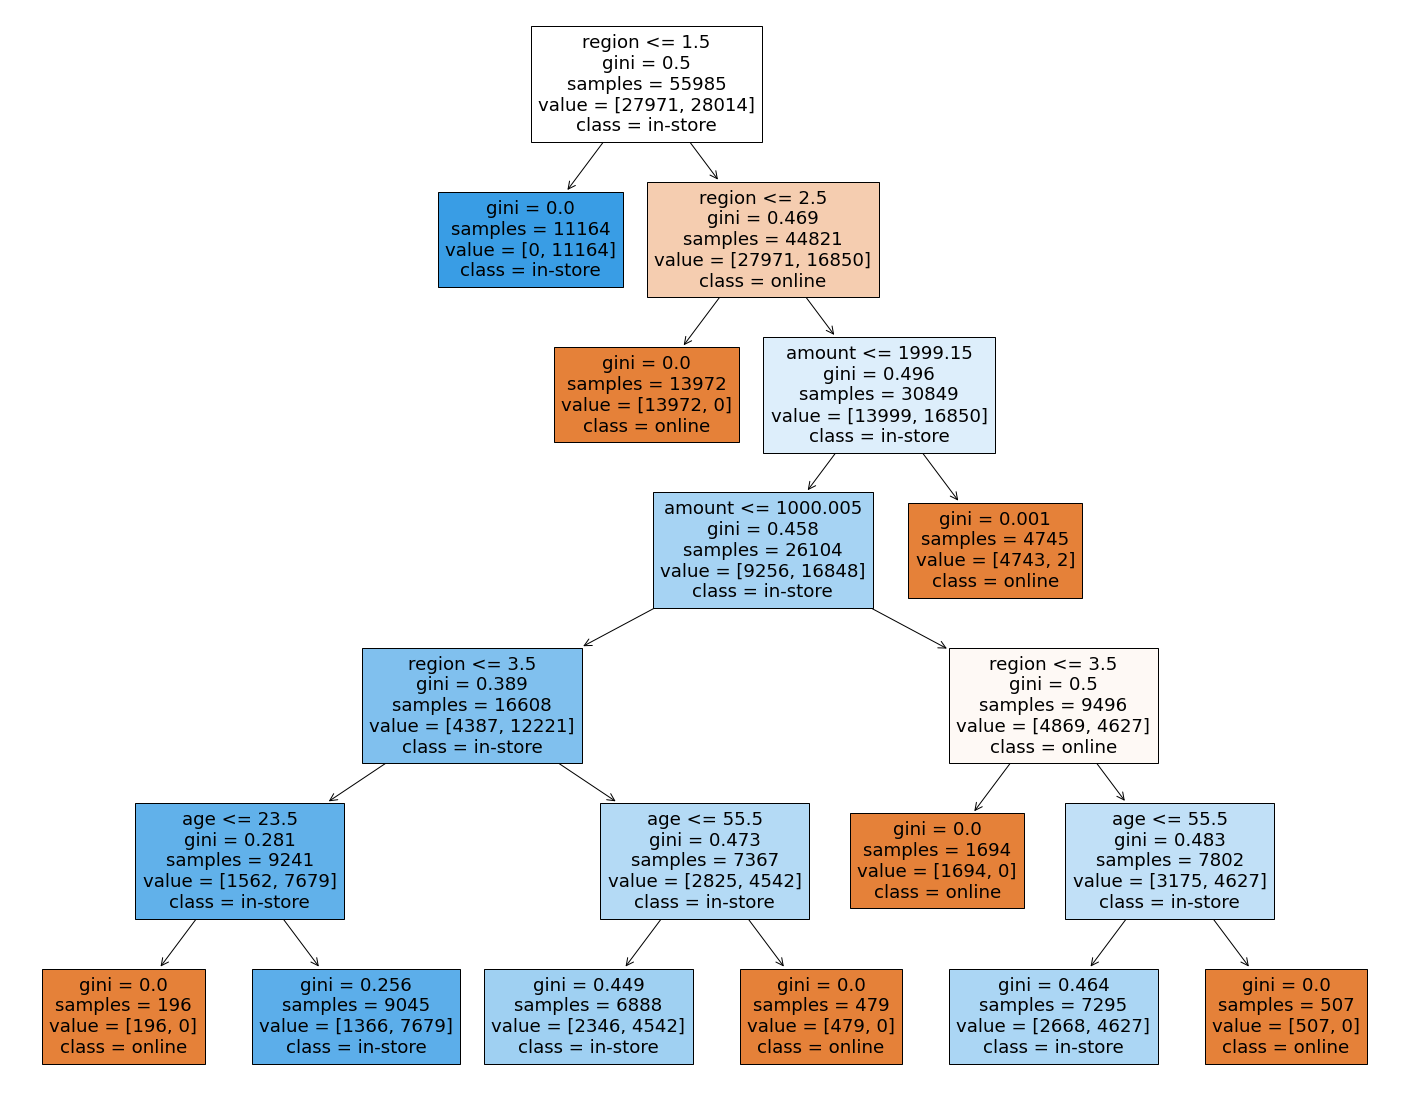

In [53]:
fig2 = plt.figure(figsize=(25,20))
_ = plot_tree(tree_model2, feature_names=x_data2.columns, class_names=['online','in-store'], filled=True)

## Conclusion

To conclude, after our analysis we can predict that in the West, where the avearge age is the lolwest (39 years), customers between 55 and 70 will buy online and younger clients will choose shops. 

In the East people younger than 23 years, spending less than 1000, will choose online transactions and elder people,spending less than 1000, would like to go to shop. However in general people prefer to pay online while making shopping which will cost more than 2000.

About the southern and the northern region we don't have a lot of information. In the South live people on average in the age of 57 which buy only online and in the North customers buy only in stores.

Moreover, we can make general insights, that young people mostly buy in stores but spend more money online, elder customers (from 60-75) spend more money shooping in-store but more frequently choose online purchases and people elder than 75 buy only in shops.
